In [2]:
# general 
import pandas as pd 
import numpy as np 
import pickle
import math

import pyarrow as pa
import pyarrow.parquet as pq

# stats
from scipy import stats
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 5)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# arima
import pmdarima as pm
from pmdarima import autocorr_plot, plot_acf, plot_pacf
from pmdarima.model_selection import train_test_split

# from common files
from common import timeseries_evaluation_metrics_func, adfuller_test, grangers_causation_matrix

# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load all dataframes
cgm_df = pd.read_parquet("Parquet Files/cgm_df.parquet.gzip")
final_df = pd.read_parquet("Parquet Files/final_df.parquet.gzip")
full_day_min_cgm = pd.read_parquet("Parquet Files/full_day_min_cgm.parquet.gzip")

## ARIMA

- Pure ARIMA for glucose
- ARIMAX with HRV exogenous variables
- VARMA with HRV exogenous variables

For the remainder of the methods, only a simple time series split will be performed, so as to lessen computation time.

full_day_min_cgm information:
- 5 min sampling of CGM data from day 2 to day 6 (5 days)
- 1728 rows, 1 column ('glucose')
- intepolated median values

In [4]:
# final day of test set for validation
TEST_SIZE_PERCENT = 0.16667

# split using pmdarima's TTS to not shuffle data
y_train, y_test = train_test_split(full_day_min_cgm, test_size=TEST_SIZE_PERCENT)

print(f"Training set shape: {y_train.shape}")
print(f"Test set shape: {y_test.shape}")

Training set shape: (1439, 1)
Test set shape: (289, 1)


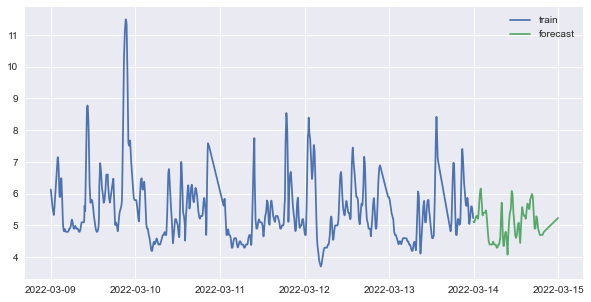

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_train, label='train')
ax.plot(y_test, label='forecast')
ax.legend()

In [6]:
# perform augmented dickey fuller test for unit root
adfuller_test(y_train, name="Glucose")

    Augmented Dickey-Fuller Test on "Glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7832
 No. Lags Chosen       = 13
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



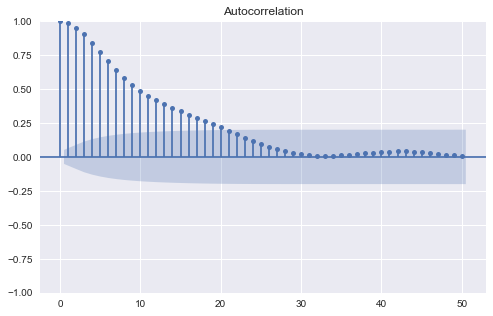

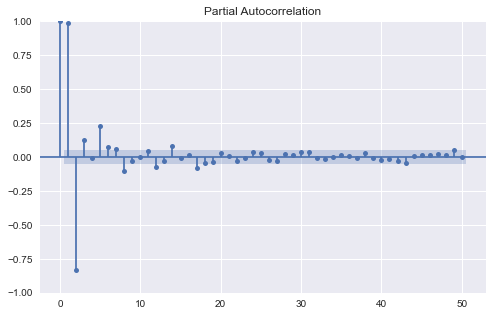

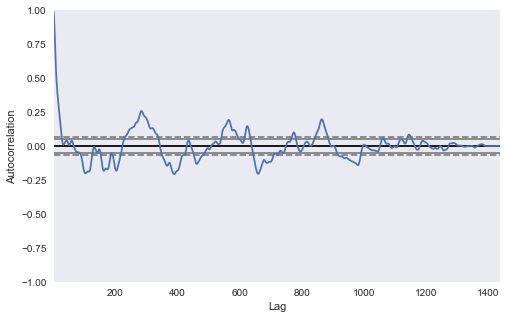

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
acf = plot_acf(y_train, ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
pacf = plot_pacf(y_train, ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
autocorr_plot(y_train)

As seen, autocorrelation up til 19, and partial autocorrelation up to 5.

# ARIMA

In [8]:
model = pm.auto_arima(y_train,
                      trace=True,
                      max_p=5, max_q=20, max_order=25,
                      stepwise=True,
                      seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2433.262, Time=1.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4232.316, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-967.908, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2349.922, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9077.461, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2128.312, Time=2.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2435.243, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1871.745, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2436.228, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2435.245, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2440.115, Time=2.45 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-2438.154, Time=2.96 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2432.265, Time=3.55 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-2433.311, Time=0.86 sec
 ARIMA(4,0,2)(0,0,0)[0]

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1439
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1226.057
Date:                Fri, 01 Apr 2022   AIC                          -2440.115
Time:                        09:51:17   BIC                          -2408.484
Sample:                             0   HQIC                         -2428.307
                               - 1439                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2335      0.036      6.408      0.000       0.162       0.305
ar.L1          1.0500      0.182      5.782      0.000       0.694       1.406
ar.L2          0.4714      0.327      1.442      0.149      -0.169       1.112
ar.L3         -0.5633      0.150     -3.754      0.000      -0.857      -0.269
ma.L1          0.7660      0.179      4.289      0.000       0.416       1.116
sigma2         0.0106      0.000     96.938      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):            151090.10
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
test_pred, confint = model.predict(n_periods=len(y_test), return_conf_int=True)
arima_rmse = timeseries_evaluation_metrics_func(y_test, test_pred)
print(f"Mean RMSE for ARIMA forecast: {arima_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 0.6863329721339333.


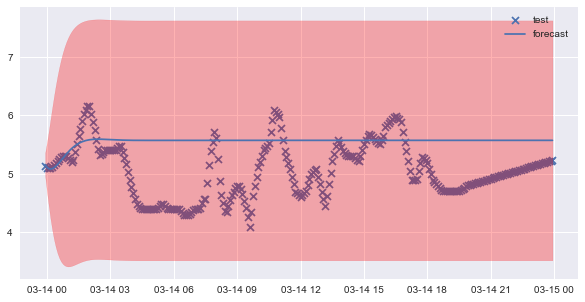

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test.index, y_test, marker='x', label='test')
ax.plot(y_test.index, test_pred, label='forecast')
ax.fill_between(y_test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

# ARIMAX 
ARIMA + exogenous variables from HRV time domain/frequence domain features

final_df information:
- 5 minute data from 0950 to 2150 hours from day 2 to day 6 (12 hours per day)
- 24 columns, including the CGM values for the 9 hours
- 868 rows

Stationarity checks with ADFuller

In [12]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(final_df)

    Augmented Dickey-Fuller Test on "glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1584
 No. Lags Chosen       = 5
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "mean_nni" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6742
 No. Lags Chosen       = 2
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "sdnn" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [13]:
fig = px.scatter(final_df)
fig.show()

In [14]:
# final day of test set for validation
TEST_SIZE_PERCENT = 0.16667

# split using pmdarima's TTS to not shuffle data
y_train, y_test = train_test_split(final_df, test_size=TEST_SIZE_PERCENT)
print(f"Shape of train: {y_train.shape}, shape of test: {y_test.shape}")

Shape of train: (723, 24), shape of test: (145, 24)


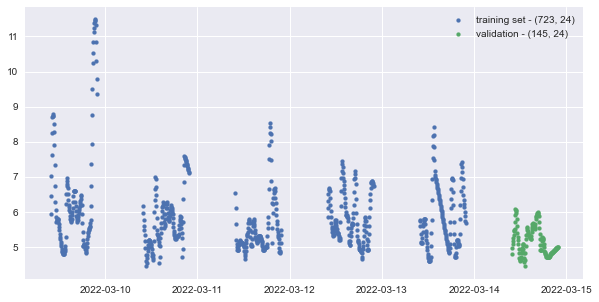

In [15]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=y_train['glucose'], x=y_train.index, label=f"training set - {y_train.shape}", s=15)
ax.scatter(y=y_test['glucose'], x=y_test.index, label=f"validation - {y_test.shape}", s=15)
ax.legend()

In [16]:
from pmdarima.utils import plot_acf, plot_pacf, autocorr_plot

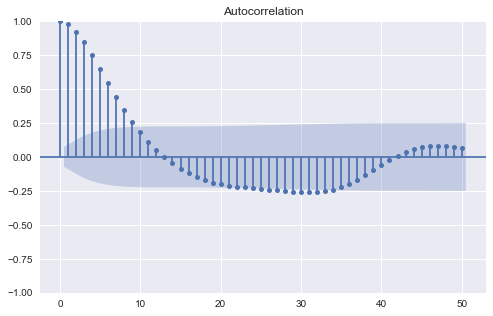

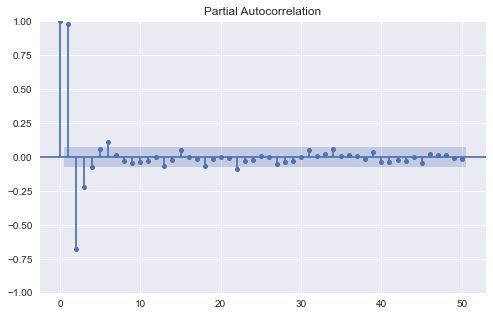

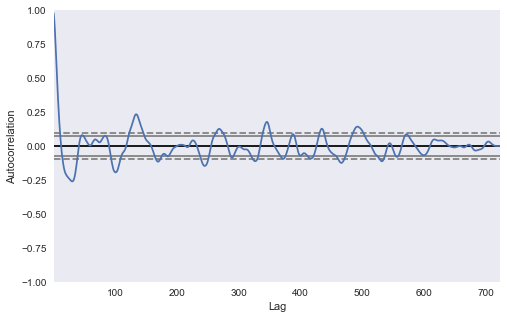

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
acf = plot_acf(y_train['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
pacf = plot_pacf(y_train['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
autocorr_plot(y_train['glucose'])

Possible params for p term: 8, q term: 3.

In [18]:
# passing in HRV params as exogenous variables
model = pm.auto_arima(y=y_train['glucose'],
                      x=y_train.drop('glucose', axis=1), maxiter=100, 
                      seasonal=True, error_action='ignore',
                      suppress_warnings=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-450.314, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2173.610, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27.205, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1300.323, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4639.460, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-328.094, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-450.038, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-446.101, Time=1.97 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-456.156, Time=1.34 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-378.830, Time=1.54 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-455.188, Time=2.74 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-455.749, Time=1.56 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-422.616, Time=0.93 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-453.927, Time=1.49 sec
 ARIMA(2,0,3)(0,0,0)[0]           

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  723
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 235.078
Date:                Fri, 01 Apr 2022   AIC                           -456.156
Time:                        09:51:43   BIC                           -424.072
Sample:                             0   HQIC                          -443.772
                                - 723                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2556      0.042      6.142      0.000       0.174       0.337
ar.L1          1.7182      0.045     37.841      0.000       1.629       1.807
ar.L2         -0.7618      0.042    -18.124      0.000      -0.844      -0.679
ma.L1         -0.2979      0.056     -5.286      0.000      -0.408      -0.187
ma.L2          0.0792      0.038      2.104      0.035       0.005       0.153
ma.L3          0.1275      0.040      3.165      0.002       0.049       0.206
sigma2         0.0304      0.001     50.219      0.000       0.029       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            227061.38
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -3.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        89.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
test_pred, confint = model.predict(n_periods=len(y_test), return_conf_int=True)
sarimax_rmse = timeseries_evaluation_metrics_func(y_test['glucose'], test_pred)
print(f"Mean RMSE for ARIMA forecast: {sarimax_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 0.8034402144983925.


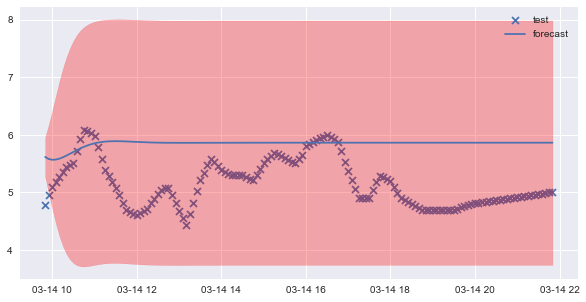

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test.index, y_test['glucose'], marker='x', label='test')
ax.plot(y_test.index, test_pred, label='forecast')
ax.fill_between(y_test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

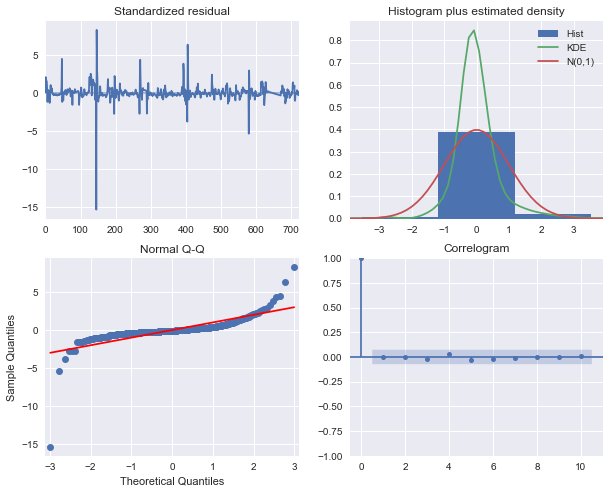

In [22]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

# VARMAX
Since data is multivariate, a forecast attempt can be made with each column as a vector, modelling each column as lagged regressors of the other features + t-lag time series. Focusing only on 'glucose'.

Granger Casuality Test

Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [23]:
matrix = grangers_causation_matrix(y_train, variables=y_train.columns)
matrix

,glucose_x,mean_nni_x,sdnn_x,sdsd_x,nni_50_x,pnni_50_x,nni_20_x,pnni_20_x,rmssd_x,median_nni_x,...,max_hr_x,min_hr_x,std_hr_x,lf_x,hf_x,lf_hf_ratio_x,lfnu_x,hfnu_x,total_power_x,vlf_x
glucose_y,1.0000,0.0152,0.0011,0.0019,0.0027,0.0035,0.0455,0.0180,0.0019,0.0186,...,0.0080,0.0033,0.0605,0.0982,0.0188,0.5551,0.0394,0.0394,0.0085,0.0096
mean_nni_y,0.6028,1.0000,0.0000,0.0296,0.3405,0.3353,0.0275,0.1330,0.0297,0.0206,...,0.2001,0.0000,0.0033,0.0036,0.0541,0.0022,0.0007,0.0007,0.0090,0.0154
sdnn_y,0.0228,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0001,0.0000,0.1590,0.0425,0.0425,0.0016,0.1881
sdsd_y,0.4099,0.0000,0.3913,1.0000,0.0000,0.0000,0.2629,0.0004,0.0128,0.0000,...,0.0086,0.0279,0.0028,0.0174,0.0000,0.6030,0.1415,0.1415,0.4296,0.5165
nni_50_y,0.4099,0.0003,0.4710,0.2007,1.0000,0.0001,0.4943,0.0228,0.2003,0.0003,...,0.0034,0.0433,0.0095,0.0282,0.0003,0.3342,0.1206,0.1206,0.3599,0.3495
pnni_50_y,0.3622,0.0028,0.1018,0.1309,0.0421,1.0000,0.6744,0.2086,0.1310,0.0086,...,0.0446,0.0095,0.5505,0.0138,0.0077,0.1023,0.0472,0.0472,0.4871,0.4718
nni_20_y,0.5843,0.0000,0.2891,0.0435,0.1317,0.0184,1.0000,0.0024,0.0434,0.0002,...,0.0000,0.0000,0.0003,0.1015,0.2625,0.0385,0.0086,0.0086,0.0926,0.0554
pnni_20_y,0.5256,0.0045,0.0167,0.1847,0.5891,0.4821,0.2620,1.0000,0.1849,0.0498,...,0.0247,0.0000,0.2596,0.0905,0.1722,0.0050,0.0039,0.0039,0.0978,0.0353
rmssd_y,0.4092,0.0000,0.3908,0.0132,0.0000,0.0000,0.2636,0.0004,1.0000,0.0000,...,0.0086,0.0281,0.0028,0.0174,0.0000,0.6025,0.1411,0.1411,0.4293,0.5167
median_nni_y,0.7066,0.0000,0.0023,0.0139,0.1285,0.1637,0.0039,0.0008,0.0139,1.0000,...,0.0075,0.0000,0.2471,0.0088,0.0354,0.0081,0.0011,0.0011,0.0542,0.0781


*_x are the independent variables, *_y are dependent variables. First row is of interest (only glucose_y)
- For most attributes (e.g. mean_nni_x, sdnn_x, etc) the null hypothesis of 0.05 is the threshold for which the x variable granger causes y
- Most variables seem to granger cause *_y.

In [24]:
rel_metrics = matrix.iloc[0]
GRANGER_THRESHOLD = 0.05

def metric_select(srs, threshold=GRANGER_THRESHOLD):
    # drop metrics that fail 0.05 granger null hypothesis threshold
    s = srs.copy()
    for idx, metric in s.iteritems():
        if metric >= GRANGER_THRESHOLD:
            s.drop(idx, inplace=True)
    return s

def extract_metrics(srs):
    keys = list(srs.keys())
    return [i[:-2] for i in keys]

feat = extract_metrics(metric_select(rel_metrics))

# add glucose
feat.insert(0, 'glucose')

In [25]:
train_best_feat = y_train[feat]
print(f"Features to use: {feat}")

Features to use: ['glucose', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'max_hr', 'min_hr', 'hf', 'lfnu', 'hfnu', 'total_power', 'vlf']


In [26]:
from dask.distributed import Client
client = Client(threads_per_worker=3, n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60308,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.95 GiB
Comm: tcp://127.0.0.1:60337,Total threads: 3
Dashboard: http://127.0.0.1:60338/status,Memory: 7.99 GiB
Nanny: tcp://127.0.0.1:60314,


In [27]:
import dask
import re

@dask.delayed
def extract_ideal_pdq(s):
    param = re.findall("S?ARIMA+X?\(([0-9]+), ([0-9]+), ([0-9]+)", s)
    p, d, q = int(param[0][0]) , int(param[0][1]) , int(param[0][2])
    return (p, d, q)

@dask.delayed
def feat_search(df_col, col, p=10, d=10, q=10):
    model = pm.arima.AutoARIMA(max_p=p, max_d=d, max_q=q, test='adf', max_order=None, seasonal=True,
                               max_iter=100, suppress_warnings=True)
    model.fit(df_col)
    return str(model.summary())

def parallel_autoarima(df):
    r = []
    for column in df.columns:
        sum = feat_search(df[column], column)
        order = extract_ideal_pdq(sum)
        r.append((column, order))
    return r

In [28]:
%%time
jobs = parallel_autoarima(train_best_feat)
ideal_params = dask.compute(*jobs)

CPU times: total: 9.16 s
Wall time: 56.6 s


In [29]:
for p in ideal_params:
    print(p) # narrow VAR hyperparameter search to p and q from individual feature list

('glucose', (2, 0, 3))
('mean_nni', (1, 0, 2))
('sdnn', (1, 0, 2))
('sdsd', (1, 0, 1))
('nni_50', (1, 0, 1))
('pnni_50', (2, 0, 1))
('nni_20', (1, 0, 0))
('pnni_20', (1, 0, 2))
('rmssd', (1, 0, 1))
('median_nni', (1, 0, 2))
('range_nni', (4, 0, 3))
('cvsd', (3, 0, 0))
('cvnni', (1, 0, 0))
('max_hr', (1, 0, 1))
('min_hr', (3, 0, 1))
('hf', (1, 0, 1))
('lfnu', (1, 0, 1))
('hfnu', (1, 0, 1))
('total_power', (2, 0, 0))
('vlf', (2, 0, 0))


In [30]:
from sklearn.compose import ColumnTransformer
FEATURES_TO_USE = feat

ct = ColumnTransformer(
    [("scaler", StandardScaler(),
      FEATURES_TO_USE)])

scaled_train = ct.fit_transform(y_train)
scaled_test = ct.transform(y_test)

In [31]:
y_train_feat_scaled = pd.DataFrame(scaled_train,
                                columns=feat,
                                index=y_train.index)

y_test_feat_scaled = pd.DataFrame(scaled_test,
                            columns=feat,
                            index=y_test.index)

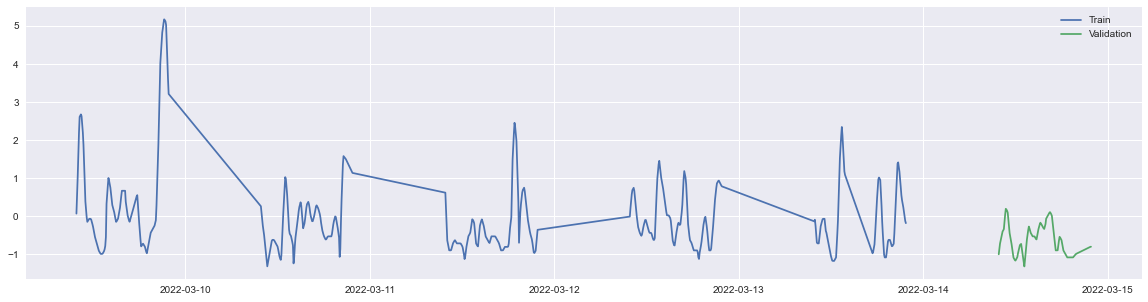

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(y_train_feat_scaled['glucose'], label='Train')
ax.plot(y_test_feat_scaled['glucose'], label='Validation')
ax.legend()

In [33]:
# extract unique ideal params from ideal params tuple
par = list(set([(_[1][0], _[1][2]) for _ in ideal_params]))
print(par)

[(1, 2), (2, 1), (4, 3), (3, 1), (1, 1), (2, 0), (3, 0), (2, 3), (1, 0)]


In [34]:
# too many features result in a non-pos estimate. trying out with selected features
s_features = ['glucose', 'sdnn', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'max_hr',
             'min_hr', 'hf', 'total_power', 'vlf']

y_train_feat_scaled = y_train_feat_scaled[s_features]
y_test_feat_scaled = y_test_feat_scaled[s_features]

In [35]:
# def varma_harness(fixed, order):  
#     model = VARMAX(fixed['train'], order=order, trace=True)
#     res = model.fit()
#     fcast = res.get_forecast(fixed['pred_len'])
#     metrics = timeseries_evaluation_metrics_func(fixed['val'][fixed['variable']],
#                                               fcast.predicted_mean[fixed['variable']].values)
#     return {'p' : order[0], 'q' : order[1], 'metrics' : metrics, 'fcast': fcast}

@dask.delayed
def varma_harness(params, order):  
    model = VARMAX(endog=params, order=order)
    return model

@dask.delayed
def varma_fit_forecast(model, pred_len):
    res = model.fit()
    fcast = res.get_forecast(pred_len)
    return fcast

@dask.delayed
def eval_model(fcast, test):
    metrics = timeseries_evaluation_metrics_func(fcast, test)
    return metrics

def gridsearch_varma(train, test, possible_params, target='glucose'):
    r = []
    for combi in possible_params:
        mod = varma_harness(train, order=combi)
        fcast = varma_fit_forecast(mod, len(test))
        results = eval_model(test[target], fcast.predicted_mean[target])
        r.append((combi, results, fcast))
    return r

        
# def gridsearch_dask(model, fixed_params, possible_params):
#     r = []
#     for combi in possible_params:
#         lazy_res = dask.delayed(model)(fixed_params, combi)
#         r.append(lazy_res)
#     return r

In [36]:
%%time
jobs = gridsearch_varma(y_train_feat_scaled,  y_test_feat_scaled, par)
varma_scores = dask.compute(*jobs)

KeyboardInterrupt: 

In [ ]:
# %%time
# jobs = gridsearch_dask(varma_harness, fixed_params={
#         'train': y_train_feat_scaled,
#         'val': y_test_feat_scaled,
#         'variable': 'glucose',
#         'pred_len': len(y_test_feat_scaled)
#     }, possible_params=par)
# varma_scores = dask.compute(*jobs)

In [ ]:
pd.DataFrame(varma_scores) # p=1, q=0 has the best scores

,0,1,2
0,"(1, 0)","{'rmse': 0.7195034581582376, 'mae': 0.63476196...",<statsmodels.tsa.statespace.mlemodel.Predictio...


In [ ]:
conf_int = varma_scores[4]['fcast'].conf_int()
fcast = varma_scores[4]['fcast'].predicted_mean['glucose'].values
rmse = varma_scores[4]['rmse']

rmse for VARMA: 0.7191369550996332


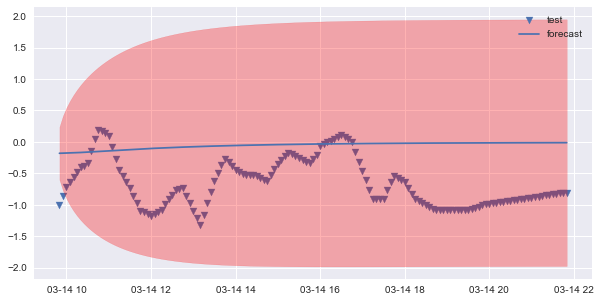

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test_feat_scaled.index, y_test_feat_scaled['glucose'], marker='v', label='test')
ax.plot(y_test_feat_scaled.index, fcast, label='forecast')
ax.fill_between(y_test_feat_scaled.index, \
                conf_int['lower glucose'], conf_int['upper glucose'], \
                color='red', alpha=0.3)
ax.legend()

print(f"rmse for VARMA: {rmse}")

# VAR(P)

Lag Order = 0
AIC :  -17.22096928140338
BIC :  -17.14489609929286
FPE :  3.3191591531148476e-08
HQIC:  -17.191606535178348 

Lag Order = 1
AIC :  -23.63785537487955
BIC :  -22.647833322708802
FPE :  5.4228817168509595e-11
HQIC:  -23.255701842200523 

Lag Order = 2
AIC :  -24.040560619044427
BIC :  -22.134608134737235
FPE :  3.626286605952971e-11
HQIC:  -23.304805938922872 

Lag Order = 3
AIC :  -24.24226718059465
BIC :  -21.41839559985509
FPE :  2.966124549969584e-11
HQIC:  -23.152098019664226 

Lag Order = 4
AIC :  -24.195276861981068
BIC :  -20.451490383065938
FPE :  3.113347155252112e-11
HQIC:  -22.749876899590564 

Lag Order = 5
AIC :  -24.167733568257667
BIC :  -19.502029216526054
FPE :  3.207941867786217e-11
HQIC:  -22.36628348146916 

Lag Order = 6
AIC :  -24.21464791460689
BIC :  -18.62501550684501
FPE :  3.0718626262154254e-11
HQIC:  -22.0563253630984 

Lag Order = 7
AIC :  -24.151047165265247
BIC :  -17.635469273785
FPE :  3.290000973986687e-11
HQIC:  -21.635026776137188 

La

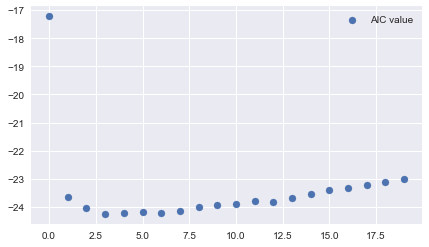

In [ ]:
model = VAR(y_train_feat_scaled)

def plot_var_aic(model, iterables):
    arr = []
    for i in iterables:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
        arr.append(result.aic)
    return arr
    
aic = plot_var_aic(model, [i for i in range(20)])


fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter([i for i in range(20)], aic, label='AIC value')
ax.legend() # select AIC value of 3

In [ ]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Mar, 2022
Time:                     20:28:50
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -21.4184
Nobs:                     720.000    HQIC:                  -23.1521
Log likelihood:          -3088.41    FPE:                2.96612e-11
AIC:                     -24.2423    Det(Omega_mle):     1.62566e-11
--------------------------------------------------------------------
Results for equation glucose
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001374         0.005987           -0.229           0.818
L1.glucose             1.426981         0.036723           38.858           0.000
L1.sdnn               -0.003584         0.045032      

#### Check Serial Correlation of Residuals
- Durbin Watson's test for serial correlation

Results of this can vary from 0-4, closer to 2, no significant correlation, close to 0, positve serial correlation and closer to 4, negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(y_train_feat_scaled.columns, out):
    print((col), ':', round(val, 2))

glucose : 2.04
sdnn : 1.99
rmssd : 2.02
median_nni : 2.01
range_nni : 1.99
cvsd : 2.05
cvnni : 1.99
max_hr : 2.01
min_hr : 1.99
hf : 2.01
total_power : 1.99
vlf : 1.99


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(f"lag_order for VAR: {lag_order}")

lag_order for VAR: 3


In [ ]:
# Input data for forecasting (e.g. last 3 time periods to forecast the first day)
forecast_input = y_train_feat_scaled.values[-lag_order:]
print(forecast_input)

[[-0.00701255 -0.31371812 -0.56211064  0.48324987 -0.15909693 -0.79339704
  -0.54168397 -0.35813584 -0.21677703 -0.64365081 -0.06257574  0.18532436]
 [-0.12704465  0.69167999 -0.03623485  0.34563184  0.18260996 -0.15014794
   0.54994541 -0.17799707 -0.21338678 -0.48056534  1.80097202  2.20896219]
 [-0.1864462  -0.33575056 -0.11568215  0.48074772 -0.61251568 -0.32506703
  -0.53136022 -0.39550121 -0.01487523 -0.44316936 -0.10506747  0.08304236]]


In [ ]:
forecast = pd.DataFrame(model_fitted.forecast(y=forecast_input,
                                              steps=len(y_test_feat_scaled)),
                        index=y_test_feat_scaled.index, 
                        columns=y_test_feat_scaled.columns)

rmse for VARMA: 0.7191369550996332


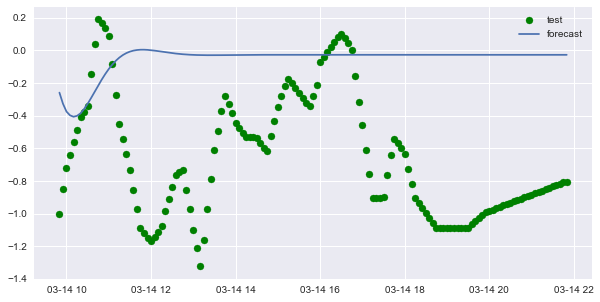

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test_feat_scaled.index, y_test_feat_scaled['glucose'], label='test',
           color='green')
ax.plot(forecast['glucose'], label='forecast')
ax.legend()

print(f"rmse for VARMA: {rmse}")

In [ ]:
all_df

NameError: name 'all_df' is not defined

In [ ]:
ct.named_transformers_['scaler'].inv

StandardScaler()

In [ ]:
lag_order_results.selected_orders

{'aic': 3, 'bic': 2, 'hqic': 2, 'fpe': 3}

In [ ]:
results = model.fit(maxlags=15, ic='aic')

In [ ]:
lag_order = results.k_ar

In [ ]:
prior = train_all_scaled.iloc[-lag_order:][train_all_scaled.columns].to_numpy()
fcast = results.forecast(prior, 145)

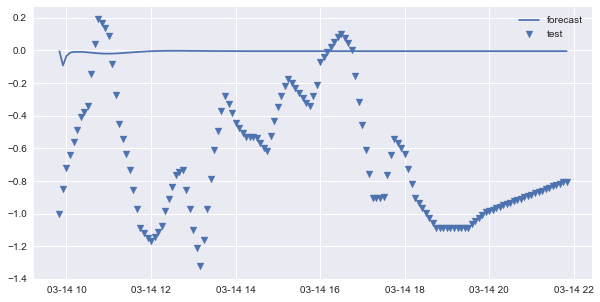

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(val_all_scaled.index, fcast[:,0], label='forecast')
ax.scatter(val_all_scaled.index, val_all_scaled['glucose'], marker='v', label='test')
ax.legend()